In [2]:
import itertools
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.markers as markers
import numpy as np
from os.path import join
from json import load
from matplotlib import rc
import matplotlib.font_manager as fm
import matplotlib.patches as mpatches
def flip(items, ncol):
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])


# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('text', usetex=True)
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

def diff(v1, v2):
    return (v1-v2)*100/v1

def get_motion_activity(video, fps, duration):
    with open(f"/home/akram/ucalgary/research/istream-player/dataset/videos-raw/motion_activity/{video}.json") as f:
        ma = load(f)
    return np.array([sum(ma[fps * s : fps * (s + 1)]) / fps for s in range(duration)])

def get_segment_sizes(video, duration, seg_type, crf):
    dash_dir = f"/home/akram/ucalgary/research/istream-player/dataset/videos-raw/dash/{video}/{video}1s_{duration}s_{seg_type}_crf{crf}"
    return np.array([os.path.getsize(f"{dash_dir}/segment_{s+1}.m4s") for s in range(duration)])


,bbb_motion_activity,bbb_size_i_crf60,bbb_size_s_crf60
bbb_motion_activity,1.00,-0.02,0.02
bbb_size_i_crf60,-0.02,1.00,0.84
bbb_size_s_crf60,0.02,0.84,1.00


,tos_motion_activity,tos_size_i_crf60,tos_size_s_crf60
tos_motion_activity,1.00,0.83,0.87
tos_size_i_crf60,0.83,1.00,0.97
tos_size_s_crf60,0.87,0.97,1.00


,elephant_motion_activity,elephant_size_i_crf60,elephant_size_s_crf60
elephant_motion_activity,1.00,0.87,0.87
elephant_size_i_crf60,0.87,1.00,0.99
elephant_size_s_crf60,0.87,0.99,1.00


,sintel_motion_activity,sintel_size_i_crf60,sintel_size_s_crf60
sintel_motion_activity,1.00,0.72,0.80
sintel_size_i_crf60,0.72,1.00,0.98
sintel_size_s_crf60,0.80,0.98,1.00


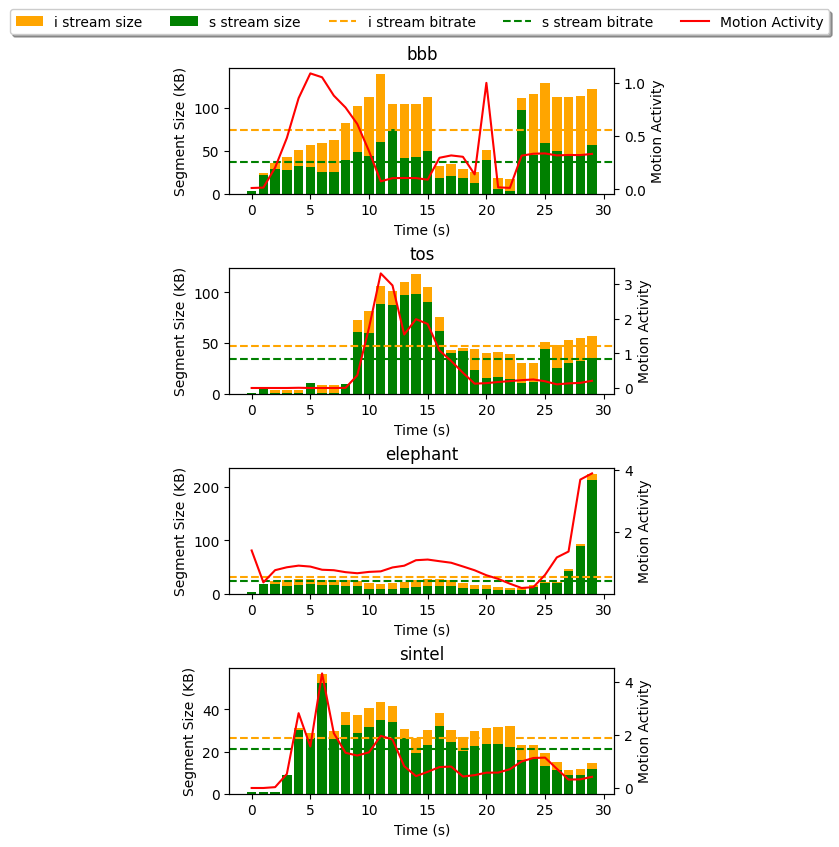

In [3]:
fig, ax = plt.subplots(4, 1, constrained_layout=True, figsize=(5, 8))
videos = ["bbb", "tos", "elephant", "sintel"]
crf = 45
duration = 30
fps = 24
df = pd.DataFrame({"time": range(duration)})

for video in videos:
    df[f"{video}_motion_activity"] = get_motion_activity(video, fps, duration)

    for seg_type in ('i', 's'):
        for crf in range(30, 61, 5):
            dash_dir = f"/home/akram/ucalgary/research/istream-player/dataset/videos-raw/dash/{video}/{video}1s_{duration}s_{seg_type}_crf{crf}"
            df[f"{video}_size_{seg_type}_crf{crf}"] = [os.path.getsize(f"{dash_dir}/segment_{s+1}.m4s") for s in range(duration)]

lns = []
for ax, video in zip(ax, videos):
    lns = []
    ax2 = ax.twinx()
    lns.append(ax.bar(df.time, df[f"{video}_size_i_crf{crf}"] / 1000, label=f"size_i_crf{crf}", color='orange'))
    lns.append(ax.bar(df.time, df[f"{video}_size_s_crf{crf}"] / 1000, label=f"size_s_crf{crf}", color='green'))
    ax.set_ylabel("Segment Size (KB)")
    ax.set_xlabel("Time (s)")
    ax.set_title(video)

    lns.append(ax.axhline(y=df[f"{video}_size_i_crf{crf}"].mean() / 1000,color='orange',linestyle='--'))
    lns.append(ax.axhline(y=df[f"{video}_size_s_crf{crf}"].mean() / 1000,color='green',linestyle='--'))

    lns.append(ax2.plot(df.time, df[f"{video}_motion_activity"], color="red", label='Motion Activity')[0])
    ax2.set_ylabel("Motion Activity")

    display(df[[f"{video}_motion_activity", f"{video}_size_i_crf{crf}", f"{video}_size_s_crf{crf}"]].corr(method='pearson').round(2))

fig.legend(
    lns,
    ['i stream size', 's stream size', 'i stream bitrate', 's stream bitrate', 'Motion Activity'],
    loc='lower center',
    bbox_to_anchor=(0.5, 1),
    fancybox=True, shadow=True, ncol=5
)



bbb


,h,size_i,size_s,ma
h,1.00,0.64,0.70,0.47
size_i,0.64,1.00,0.93,0.04
size_s,0.70,0.93,1.00,0.09
ma,0.47,0.04,0.09,1.00


tos


,h,size_i,size_s,ma
h,1.00,0.87,0.89,0.96
size_i,0.87,1.00,0.98,0.85
size_s,0.89,0.98,1.00,0.86
ma,0.96,0.85,0.86,1.00


elephant


,h,size_i,size_s,ma
h,1.00,0.99,0.99,0.89
size_i,0.99,1.00,0.99,0.84
size_s,0.99,0.99,1.00,0.85
ma,0.89,0.84,0.85,1.00


sintel


,h,size_i,size_s,ma
h,1.00,0.90,0.92,0.86
size_i,0.90,1.00,0.99,0.70
size_s,0.92,0.99,1.00,0.77
ma,0.86,0.70,0.77,1.00


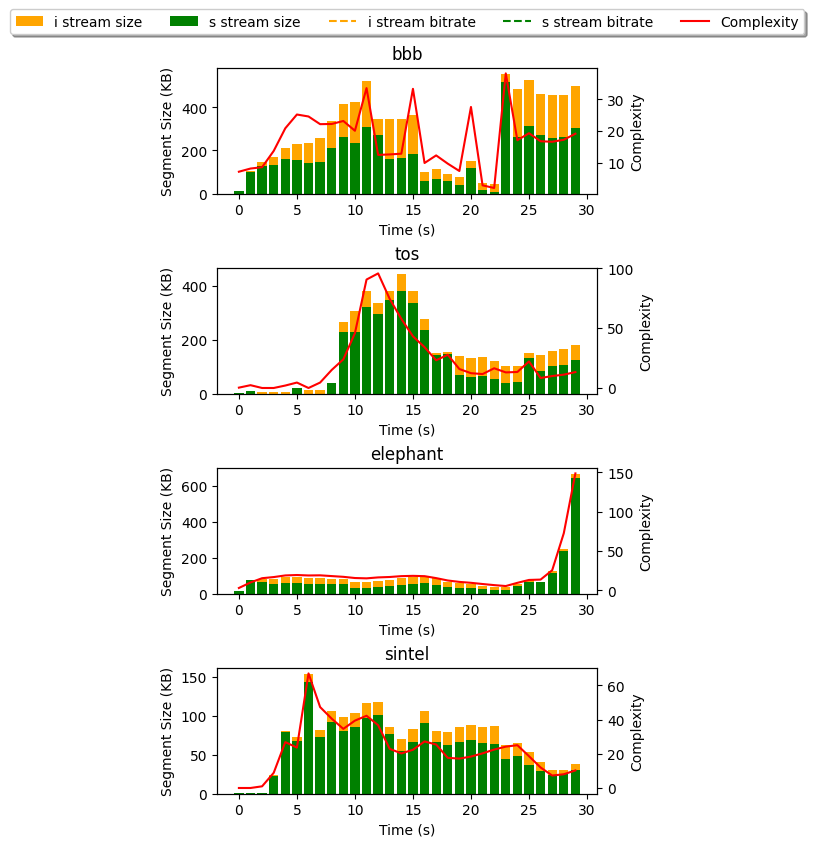

In [31]:
videos = ["bbb", "tos", "elephant", "sintel"]
fig, ax = plt.subplots(len(videos), 1, constrained_layout=True, figsize=(5, 2 * len(videos)))
crf = 45
duration = 30
fps = 24

lns = []
for i, video in enumerate(videos):

    df = pd.read_csv(f"/home/akram/ucalgary/research/istream-player/dataset/videos-raw/complexity/{video}.csv")
    df = df.groupby(np.arange(len(df)) // fps).mean()
    df.rename(columns={" avgU": "avgU", " energyU": "energyU", " avgV": "avgV", " energyV": "energyV"}, inplace=True)
    df['size_i'] = get_segment_sizes(video, duration, "i", crf) / 1000
    df['size_s'] = get_segment_sizes(video, duration, "s", crf) / 1000
    df['time'] = range(30)

    df['ma'] = get_motion_activity(video, fps, duration)


    lns.append(ax[i].bar(df.time, df.size_i, color="orange"))
    lns.append(ax[i].bar(df.time, df.size_s, color="green"))
    lns.append(ax[i].axhline(y=df["size_i"].mean(),color='orange',linestyle='--'))
    lns.append(ax[i].axhline(y=df["size_s"].mean(),color='green',linestyle='--'))

    ax[i].set_ylabel("Segment Size (KB)")
    ax[i].set_xlabel("Time (s)")
    ax[i].set_title(video)
    
    ax2 = ax[i].twinx()
    lns.append(ax2.plot(df.time, df.h, label="h", color='red')[0])
    ax2.set_ylabel("Complexity")

    print(video)
    display(df[['h', 'size_i', 'size_s', 'ma']].corr(method='pearson').round(2))


fig.legend(
    lns,
    ['i stream size', 's stream size', 'i stream bitrate', 's stream bitrate', 'Complexity'],
    loc='lower center',
    bbox_to_anchor=(0.5, 1),
    fancybox=True, shadow=True, ncol=5
)
